In [8]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from glob import glob
import yaml
from matplotlib.colors import to_hex
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [9]:
with open("../config.yaml", "r") as file:
    config = yaml.safe_load(file)

In [10]:
labels = glob("../label/*.json")
labels.sort()

In [11]:
# Read the json file
with open(labels[-1],"r") as f:
    data = json.load(f)
    print(f)

<_io.TextIOWrapper name='../label/project-5-at-2024-12-28-13-43-b75a4ec0.json' mode='r' encoding='UTF-8'>


In [12]:
entities = []
relations = []
sent_entities = []
sent_relations = []

for sentence in data:
    try:
        t_entities = []
        t_relations = []
        for annotation in sentence["annotations"][0]["result"]:
            if annotation["type"] == "labels":
                entities.append(annotation["value"]["labels"][0])
                t_entities.append(annotation["value"]["labels"][0])
            elif annotation["type"] == "relation":
                relations.append(annotation["labels"])
        sent_entities.append(list(set(t_entities)))
     #   sent_relations.append(list(set(relations)))
    except Exception as e:
        print(f"Error processing sentence: {sentence['data']['text']}: {e}")

In [13]:
sentences = [sentence["data"]["text"] for sentence in data]

check duplicated sentences. True means no duplicates

In [14]:
len(set(sentences)) == len(sentences)

True

In [15]:
len(set(sentences))

3979

In [16]:
from collections import Counter

# Count the occurrences of each sentence
sentence_counts = Counter(sentences)

# Find the duplicate sentences
duplicate_sentences = [sentence for sentence, count in sentence_counts.items() if count > 1]

print(duplicate_sentences)

[]


In [17]:
relations = [item for items in relations for item in items]
#entities = [item for items in entities for item in items]
sent_entities = [item for items in sent_entities for item in items]

In [18]:
pd.DataFrame(sent_entities).value_counts()

0        
STRAIN       2609
COMPOUND     1474
ORGANISM     1204
EFFECT       1009
PROTEIN       812
SPECIES       760
PHENOTYPE     589
ISOLATE       521
MEDIUM        373
DISEASE       350
GENE          309
GENUS         178
VIRUS         118
ASSEMBLY        6
Name: count, dtype: int64

In [19]:
ner_df = pd.DataFrame(sent_entities).value_counts().reset_index().rename(columns={0:"ner", "count":"count_per_sentence"})

Text(0.5, 1.0, 'Number of sentences with entity')

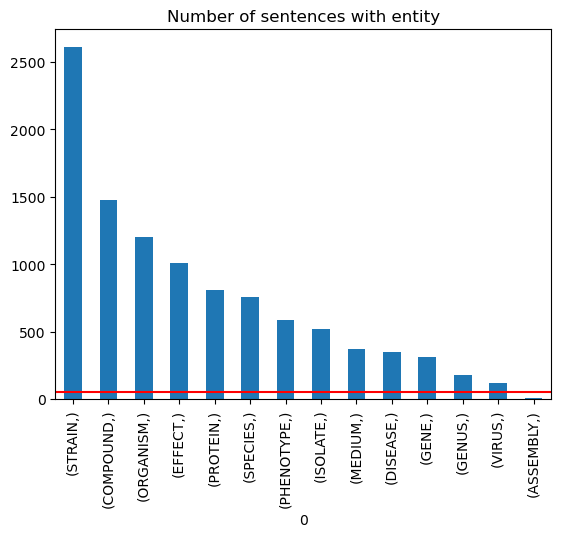

In [20]:
pd.DataFrame(sent_entities).value_counts().plot(kind='bar')
plt.axhline(50, color='red')
plt.title('Number of sentences with entity')

In [21]:
ner_df = ner_df.merge(pd.DataFrame(entities).value_counts().reset_index().rename(columns={0:"ner", "count":"count_per_entity"}))


Text(0.5, 1.0, 'Total number of entities')

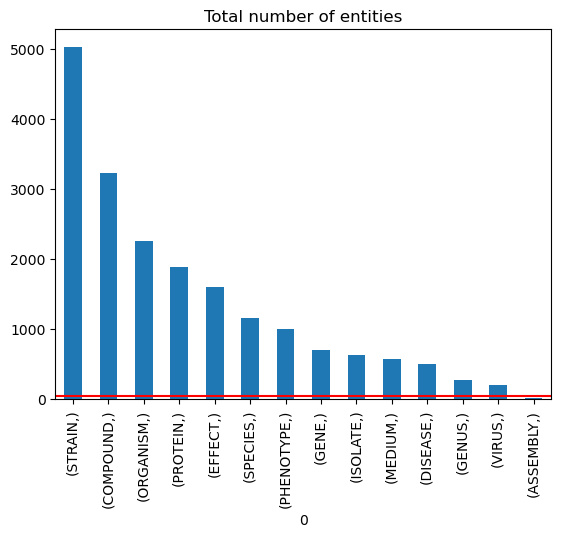

In [22]:
pd.DataFrame(entities).value_counts().plot(kind='bar')
plt.axhline(50, color='red')
plt.title('Total number of entities')

In [23]:
ner_df_m = ner_df.melt("ner", var_name="type", value_name="count")

In [24]:
ner_df_m

,ner,type,count
0,STRAIN,count_per_sentence,2609
1,COMPOUND,count_per_sentence,1474
2,ORGANISM,count_per_sentence,1204
3,EFFECT,count_per_sentence,1009
4,PROTEIN,count_per_sentence,812
5,SPECIES,count_per_sentence,760
6,PHENOTYPE,count_per_sentence,589
7,ISOLATE,count_per_sentence,521
8,MEDIUM,count_per_sentence,373
9,DISEASE,count_per_sentence,350


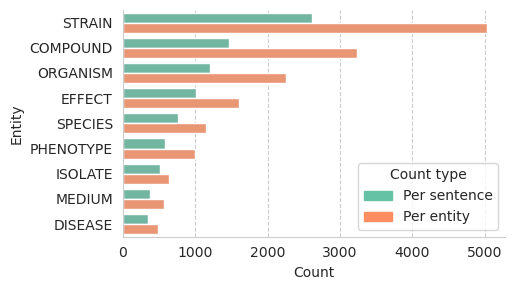

In [25]:
import matplotlib.patches as mpatches

# Define the colors for the legend
colors = ["#66c2a5", "#fc8d62"]

# Create the patches for the legend
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, ["Per sentence", "Per entity"])]

# Set the style to show faint vertical grid lines
sns.set_style("whitegrid", {"axes.grid": True, "grid.linestyle": "--", "grid.alpha": 0.3})

# Plot the graph
sns.catplot(y="ner", x="count", hue="type", kind="bar", data=ner_df_m[ner_df_m["ner"].isin(config["ner_labels"])], palette="Set2", legend=False, height=3, aspect=1.75)
plt.xlabel("Count")
plt.ylabel("Entity")
plt.legend(handles=patches, title="Count type")

plt.savefig("./figures/predictions/labeled_entities_counts.pdf")

### Correlate sizes with performance

In [26]:
metrics_ner = pd.read_csv("../NER_output/aggregated_eval.tsv",sep="\t",index_col=0)

In [27]:
ner_df_m_filter = ner_df_m[ner_df_m["ner"].isin(config["ner_labels"])].set_index("ner")

In [28]:
metrics_merged = ner_df_m_filter.merge(metrics_ner,left_index=True,right_index=True)

In [29]:
# Define your categories
categories = [
    "STRAIN", "COMPOUND", "ORGANISM", "EFFECT", 
    "SPECIES", "PHENOTYPE", "ISOLATE", "MEDIUM", "DISEASE"
]

# Get the Set3 colormap from Matplotlib
set3 = plt.get_cmap("Set3")

# List of yellowish colors to exclude
yellow_hex_codes = ['#ffffb3', '#ffd700']  # #ffffb3 is known yellow in Set3; #ffd700 is another common yellow

# Filter out yellowish colors from the Set3 colormap
valid_colors = [to_hex(set3(i)) for i in range(set3.N) if to_hex(set3(i)) not in yellow_hex_codes]

# Create the color encoding without yellow colors
color_encoding_no_yellow = {category: valid_colors[i] for i, category in enumerate(categories)}

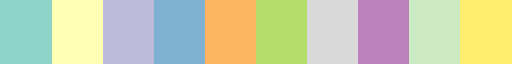

In [30]:
plt.get_cmap('Set3',10)

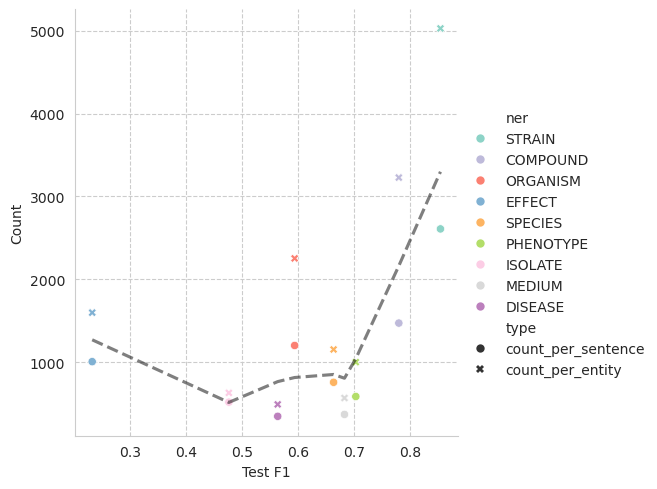

In [31]:
sns.relplot(data=metrics_merged.reset_index(), x="test_f1", y="count", hue="ner", style="type", palette=color_encoding_no_yellow)

# Add a LOESS trend line
sns.regplot(data=metrics_merged.reset_index(), x="test_f1", y="count", scatter=False, lowess=True, color='black', line_kws={'linestyle':'--', 'alpha':0.5})

plt.xlabel("Test F1")
plt.ylabel("Count")

plt.savefig("./figures/predictions/labeled_entities_to_performance.pdf")

### RELS

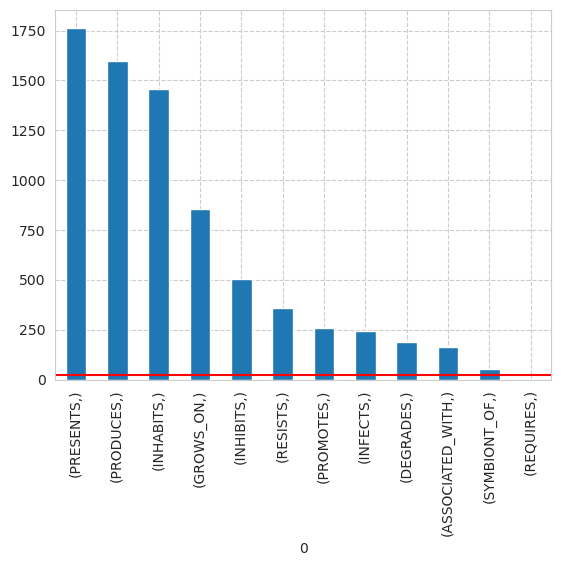

In [32]:
pd.DataFrame(relations).value_counts().plot(kind='bar')
plt.axhline(25, color='red')

In [33]:
sentence_id = []
sentence_text = []
relationships = []
for sentence in data:
    ids = {} # id -> label dictionary
    for annotation in sentence["annotations"][0]["result"]:
        if annotation["type"] == "labels":
            ids[annotation["id"]] = annotation["value"]["labels"]
#            text[annotation["id"]] = annotation["value"]["text"]
        elif annotation["type"] == "relation":
            for label in annotation["labels"]:
#            print(ids.get(annotation["from_id"]),"->", ids.get(annotation["to_id"]), ":", annotation["labels"])
                s = str(*ids.get(annotation["from_id"]))+"->"+ str(*ids.get(annotation["to_id"]))+ ":"+ str(label)
                relationships.append(s)
                sentence_text.append(sentence["data"]["text"])
                sentence_id.append(sentence["id"])

In [34]:
df = pd.DataFrame({"sentence_id":sentence_id, "text" : sentence_text,"relationship":relationships})

In [35]:
grouped = df.groupby(["sentence_id", "relationship"]).count().reset_index()
filtered = grouped[grouped["relationship"] == "STRAIN->ORGANISM:SYMBIONT_OF"]

Make split using `pd.sample`

In [36]:
counts = pd.DataFrame(relationships).value_counts()

In [37]:
df[df["relationship"]=="STRAIN->COMPOUND:INHIBITS"].text.unique()

array(['In this study, we demonstrate that a butyric acid-producing Leuconostoc mesenteroides (L. mesenteroides) EH-1 strain isolated from Mongolian curd cheese can reduce blood glucose and IL-6 in the type 1 diabetic mouse model.',
       'The results indicated that Shewanella_sp_MR-7 was positively correlated with xanthine, isoxanthopterin, and xanthopterin, but negatively correlated with dopaquinone, xanthophyll^#, and idoxanthin.'],
      dtype=object)

In [38]:
cnts = counts.reset_index()

In [39]:
cnts[(cnts[0].str.contains("STRAIN"))&(cnts["count"]>0)].set_index(0)

,count
0,
STRAIN->PHENOTYPE:PRESENTS,1055
STRAIN->ISOLATE:INHABITS,915
STRAIN->COMPOUND:PRODUCES,867
STRAIN->MEDIUM:GROWS_ON,773
STRAIN->PROTEIN:PRODUCES,490
STRAIN->ORGANISM:INHABITS,459
STRAIN->EFFECT:PRESENTS,374
STRAIN->COMPOUND:RESISTS,310
COMPOUND->STRAIN:INHIBITS,198


Text(0, 0.5, '')

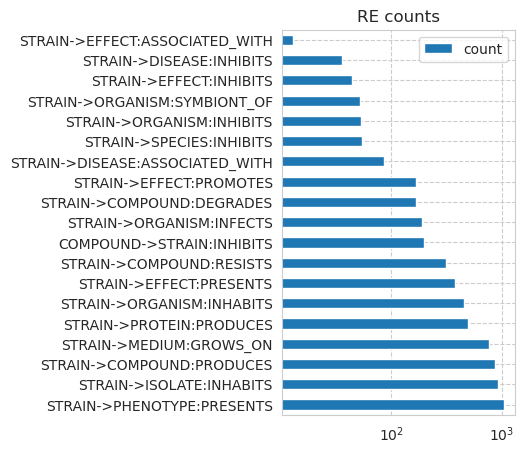

In [40]:
cnts[(cnts[0].str.contains("STRAIN"))&(cnts["count"]>12)].set_index(0).plot(kind='barh',figsize=(3,5),logx=True)
plt.title("RE counts")
plt.ylabel("")

In [41]:
c = cnts.rename(columns={0:"relationship"})

In [42]:
c["re"] = c.relationship.str.split(":",expand=True)[1]
c["ner_re"] = c.relationship.str.split(":",expand=True)[0]

In [43]:
c["non_strain_ner"] = c.relationship.str.split(":", expand=True)[0].str.split("->").apply(lambda x: [elem for elem in x if elem != "STRAIN"])


In [44]:
c["relationship"] = c.relationship.str.replace("->", "-")
c["ner_re"] = c["ner_re"].str.replace("->", "-")

In [45]:
cs = c[c['non_strain_ner'].apply(lambda x: len(x) == 1)]


In [46]:
cs.set_index("re")[["ner_re", "count"]]

,ner_re,count
re,,
PRESENTS,STRAIN-PHENOTYPE,1055
INHABITS,STRAIN-ISOLATE,915
PRODUCES,STRAIN-COMPOUND,867
GROWS_ON,STRAIN-MEDIUM,773
PRODUCES,STRAIN-PROTEIN,490
INHABITS,STRAIN-ORGANISM,459
PRESENTS,STRAIN-EFFECT,374
RESISTS,STRAIN-COMPOUND,310
INHIBITS,COMPOUND-STRAIN,198


In [47]:
cs['non_strain_ner'] = cs['non_strain_ner'].explode()


/scratch/ipykernel_370156/975501423.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cs['non_strain_ner'] = cs['non_strain_ner'].explode()


In [48]:
cs_filter = cs[(cs["count"]>24)&(cs["non_strain_ner"]!="VIRUS")&(cs["non_strain_ner"]!="PROTEIN")]

In [49]:
cs_filter

,relationship,count,re,ner_re,non_strain_ner
0,STRAIN-PHENOTYPE:PRESENTS,1055,PRESENTS,STRAIN-PHENOTYPE,PHENOTYPE
1,STRAIN-ISOLATE:INHABITS,915,INHABITS,STRAIN-ISOLATE,ISOLATE
2,STRAIN-COMPOUND:PRODUCES,867,PRODUCES,STRAIN-COMPOUND,COMPOUND
3,STRAIN-MEDIUM:GROWS_ON,773,GROWS_ON,STRAIN-MEDIUM,MEDIUM
5,STRAIN-ORGANISM:INHABITS,459,INHABITS,STRAIN-ORGANISM,ORGANISM
6,STRAIN-EFFECT:PRESENTS,374,PRESENTS,STRAIN-EFFECT,EFFECT
7,STRAIN-COMPOUND:RESISTS,310,RESISTS,STRAIN-COMPOUND,COMPOUND
8,COMPOUND-STRAIN:INHIBITS,198,INHIBITS,COMPOUND-STRAIN,COMPOUND
9,STRAIN-ORGANISM:INFECTS,190,INFECTS,STRAIN-ORGANISM,ORGANISM
10,STRAIN-COMPOUND:DEGRADES,169,DEGRADES,STRAIN-COMPOUND,COMPOUND


In [50]:
pivot_df = cs_filter.pivot_table(index='re', columns='non_strain_ner', values='count', aggfunc='sum').fillna(0)


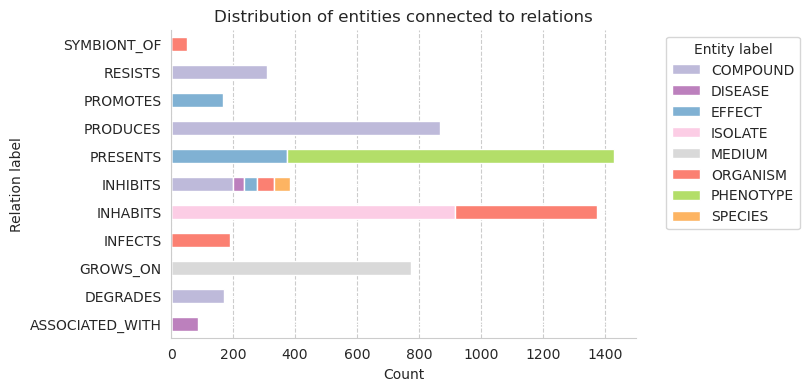

In [51]:
# # Get the colormap
# cmap = plt.get_cmap('Set3',10)
# colors = [cmap(i) for i in range(len(pivot_df.columns)+2)if i != 1 and i != 0]

# # Create a color dictionary to map each column to a color
# color_dict = {column: colors[i] for i, column in enumerate(pivot_df.columns)}

colors = [color_encoding_no_yellow[col] for col in pivot_df.columns]

ax = pivot_df.plot(kind='barh', stacked=True, color=colors, figsize=(6, 4))

plt.xlabel('Count')
plt.ylabel('Relation label')
plt.title('Distribution of entities connected to relations')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Entity label")

# Remove horizontal axis lines in the background
plt.grid(axis='y', which='both', color='white')

# Remove the right spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.savefig("./figures/predictions/relationship_distribution.pdf", bbox_inches='tight')